In [12]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [304]:
%%time
df = pd.read_excel('nyc_benchmarking_disclosure_2017_consumption_data.xlsx',
            'Information and Metrics', usecols='P, Z, AA, BA')
# BA -> GHG
# AV -> elect

CPU times: total: 36.4 s
Wall time: 46.8 s


In [305]:
# getting rid of all rows containing np.nan - useless for training
for column in df.columns:
    df = df[df[column].notna()]

# prevent division by zero in calculations
df = df[df['Total GHG Emissions (Metric Tons CO2e)'] > 0]
    
# separate X (df) and Y (GHG)
yEmissions = np.array(df.pop('Total GHG Emissions (Metric Tons CO2e)')).reshape(-1, 1)
x = np.array(df)

# linear regression
# regEm = LinearRegression().fit(x, yEmissions)
regEm = LinearRegression().fit(x, [math.log(val) for val in yEmissions])

In [310]:
# gathering information
expected, actual = [], []
errors, outliers = [], []

# making predictions for each non-np.nan entry
for index in range(len(df)):
    prediction = np.array(df.iloc[index]).reshape(1, -1)
    
    predEm = regEm.predict(prediction)[0]
    predEm = math.e ** predEm
    
    error = abs((yEmissions[index][0] - predEm) / yEmissions[index][0] * 100)
    
    expected.append(predEm)
    actual.append(yEmissions[index][0])

    # outliers... unless?
    if error < 400:
        errors.append(error)
        
#         print('PREDICTED GHG EMISSIONS:', predEm)
#         print('ACTUAL GHG EMISSIONS:', yEmissions[index][0])
#         print('ABS PERCENT ERROR:', error, '%')
#         print()
        
    else:
        outliers.append(error)

print('Average error is', round(sum(errors) / len(errors)), '%')
print(len(outliers), 'outliers;', round(len(outliers) / len(df) * 100), '% of total entries')
print('Outlier error ranges from', round(min(outliers)), '% to', round(max(outliers)), '%')

Average error is 56 %
1644 outliers; 5 % of total entries
Outlier error ranges from 401 % to 348055822556 %


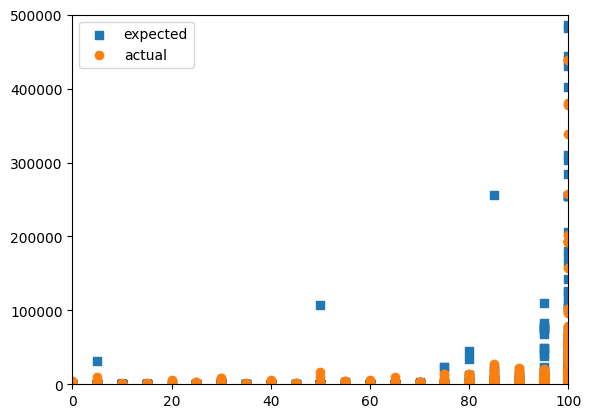

In [286]:
plt.scatter(df['Occupancy'], expected, label='expected', marker='s')
plt.scatter(df['Occupancy'], actual, label='actual', marker='o')
plt.xlim(0, 100)
plt.ylim(0, 500000)
plt.legend(loc='upper left')
plt.show()

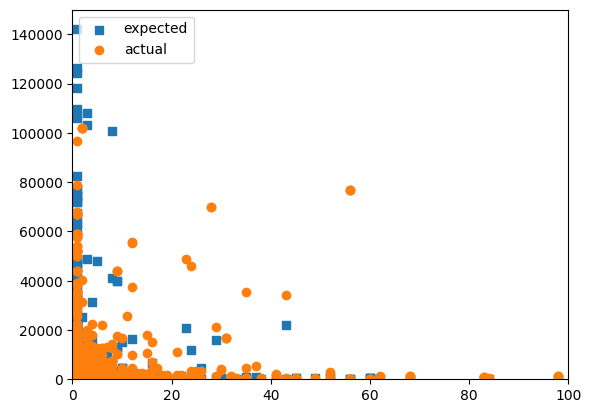

In [287]:
plt.scatter(df['Number of Buildings'], expected, label='expected', marker='s')
plt.scatter(df['Number of Buildings'], actual, label='actual', marker='o')
plt.xlim(0, 100)
plt.ylim(0, 150000)
plt.legend(loc='upper left')
plt.show()

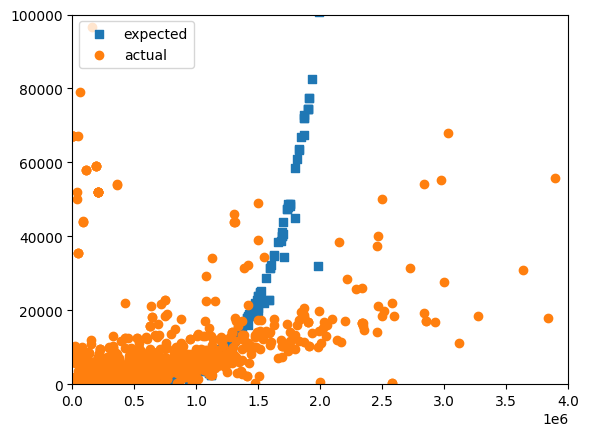

In [288]:
plt.scatter(df['Self-Reported Gross Floor Area (ft²)'], expected, label='expected', marker='s')
plt.scatter(df['Self-Reported Gross Floor Area (ft²)'], actual, label='actual', marker='o')
plt.xlim(0, 4000000)
plt.ylim(0, 100000)
plt.legend(loc='upper left')
plt.show()

(0.0, 20.0)

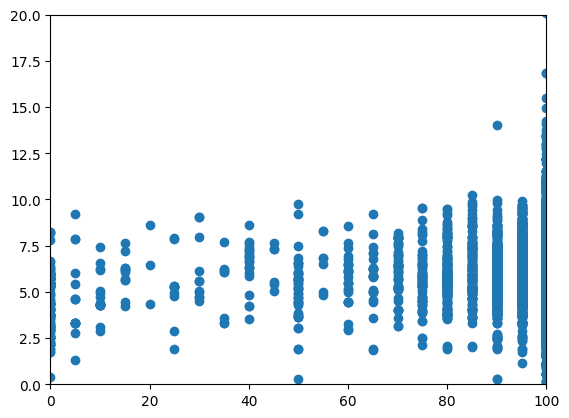

In [289]:
plt.scatter(df['Occupancy'], [math.log(val) for val in yEmissions])
plt.xlim(0, 100)
plt.ylim(0, 20)

(0.0, 20.0)

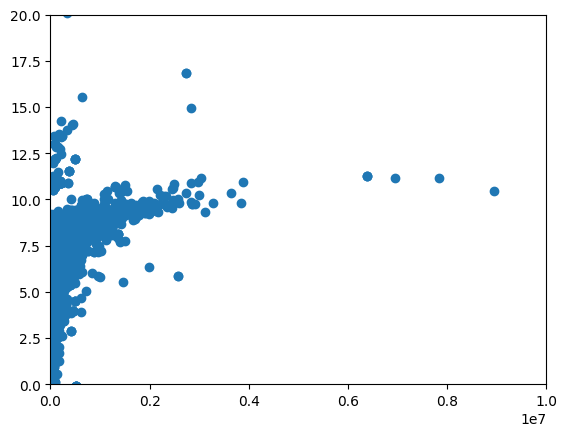

In [290]:
p = plt.scatter(df['Self-Reported Gross Floor Area (ft²)'], [math.log(val) for val in yEmissions])
plt.xlim(0, 10000000)
plt.ylim(0, 20)

(0.0, 20.0)

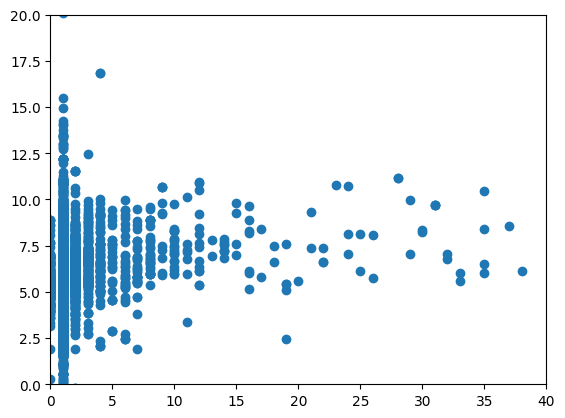

In [291]:
p = plt.scatter(df['Number of Buildings'], [math.log(val) for val in yEmissions])
plt.xlim(0, 40)
plt.ylim(0, 20)